In [2]:
import cobra
import pandas as pd
import re
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
import leakage, utils
import seaborn as sns
from matplotlib import cm, colors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib
import matplotlib.gridspec as gridspec
import statsmodels.api as sm

# Read files, define colormap etc

In [3]:
# df = pd.read_csv('spreadsheet_ecoli_leakage_and_info_230626_owd_significant.csv', index_col = 0)
only_significant_changes = False
timepoints = np.arange(4.5, 9, 1)
knock_outs = False
shadow_price_for_leaked_mets = True


#################
if only_significant_changes:
    s1 = '_osc'
else:
    s1 = ''

if shadow_price_for_leaked_mets:
    s2 = '_SP_for_leaked'
else:
    s2 = ''

if knock_outs:
    s3 = '_KO'
else:
    s3 = ''
    

species = 'e_coli'
timestr = '20230703'#'20230629'
fn = 'spreadsheet_{0}_leakage_{1}{2}{3}{4}.csv'.format(species, timestr, s1, s2, s3)
folder = Path('../../results/{0}/'.format(species))

df = pd.read_csv(folder / fn, index_col = 0)

In [4]:
# df['log10(Leakage [mmol/gDW/h])'] = df['log10(leakage)']
df['Shadow price [gDW/mmol]'] = df['Shadow price']
# df['log10(-Shadow price [gDW/mmol])'] = df['log10(-Shadow price [gDW/mmol)']
# df['log10(Turnover [mmol/gDW/h])'] = df['log10(Turnover)']
df['Topological Polar Surface Area [Å]'] = df['Topological Polar Surface Area []']

In [5]:
df.columns

Index(['Metabolite name', 'Metabolite id', 'Mass', 'Charge', 'Phosphate',
       'Topological Polar Surface Area []', 'Concentration', 'log P',
       'Leakage (mmol/gDW/h)', 'Time', 'Glucose', 'Predicted growth rate',
       'Shadow price', 'Turnover', 'Median log10(-Shadow price)',
       'Low log10(-Shadow price)', 'High log10(-Shadow price)',
       'Uptake (mmol/gDW/h)', 'log10(Leakage [mmol/gDW/h])',
       'log10(-Shadow price [gDW/mmol])', 'log10(Turnover [mmol/gDW/h])',
       'Shadow price [gDW/mmol]', 'Topological Polar Surface Area [Å]'],
      dtype='object')

In [6]:
cmap40 = colors.ListedColormap(cm.tab20b.colors[4:] + cm.tab20c.colors, name='tab40')
cmap40(34)

(0.7411764705882353, 0.7411764705882353, 0.7411764705882353, 1.0)

# Scatterplots and time-traces of specific parameters
- Shadow price
- log10(-Shadow price) is [gDW/mM]
- Turnover
- log P?
- Charge?


In [7]:
df.columns

Index(['Metabolite name', 'Metabolite id', 'Mass', 'Charge', 'Phosphate',
       'Topological Polar Surface Area []', 'Concentration', 'log P',
       'Leakage (mmol/gDW/h)', 'Time', 'Glucose', 'Predicted growth rate',
       'Shadow price', 'Turnover', 'Median log10(-Shadow price)',
       'Low log10(-Shadow price)', 'High log10(-Shadow price)',
       'Uptake (mmol/gDW/h)', 'log10(Leakage [mmol/gDW/h])',
       'log10(-Shadow price [gDW/mmol])', 'log10(Turnover [mmol/gDW/h])',
       'Shadow price [gDW/mmol]', 'Topological Polar Surface Area [Å]'],
      dtype='object')

<Axes: xlabel='log10(-Shadow price [gDW/mmol])', ylabel='log10(Leakage [mmol/gDW/h])'>

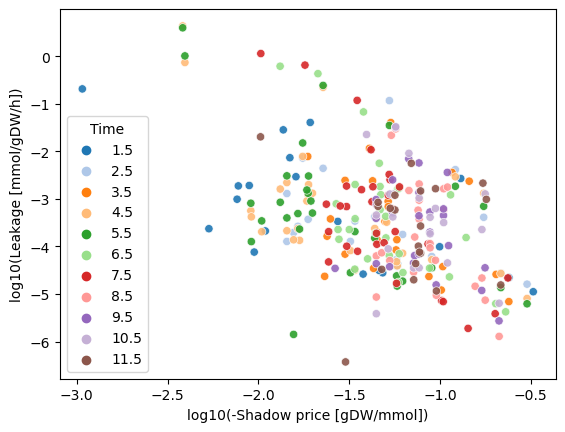

In [8]:
sns.scatterplot(data = df, x = 'log10(-Shadow price [gDW/mmol])', y = 'log10(Leakage [mmol/gDW/h])', hue = 'Time', palette = 'tab20', alpha = 0.9)
# sns.scatterplot(data = df, x = 'Low log10(-Shadow price)', y = 'log10(Leakage [mmol/gDW/h])', hue = 'Time', palette = 'tab20', alpha = 0.9)

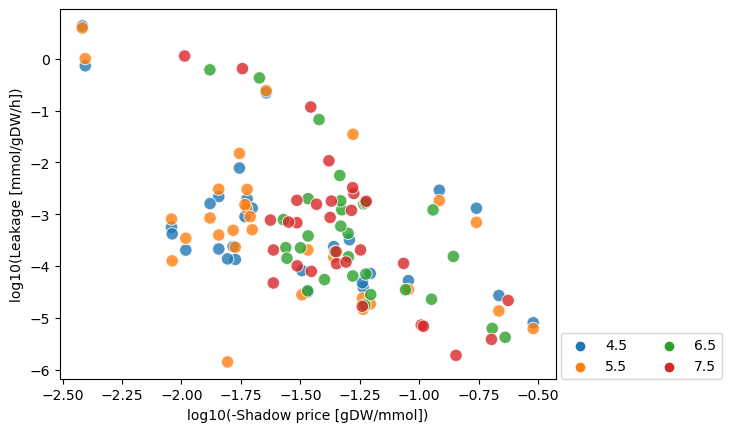

In [9]:
ax = sns.scatterplot(data = df.loc[df.Time.isin([4.5, 5.5, 6.5, 7.5]),:], x = 'log10(-Shadow price [gDW/mmol])', y = 'log10(Leakage [mmol/gDW/h])', 
                     hue = 'Time', alpha = 0.8, palette = 'tab10', s = 80)
ax.legend(ncol = 2, loc = (1.01, 0))

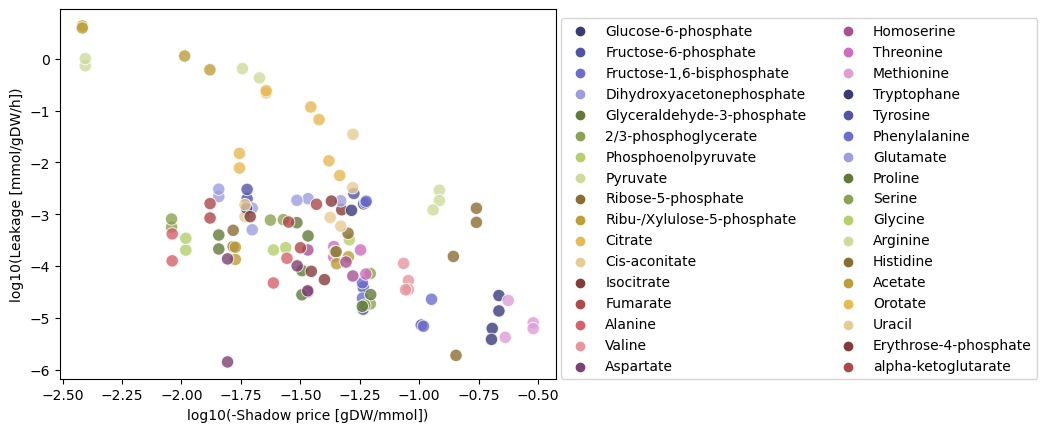

In [10]:
ax = sns.scatterplot(data = df.loc[df.Time.isin([4.5, 5.5, 6.5, 7.5]),:], x = 'log10(-Shadow price [gDW/mmol])', y = 'log10(Leakage [mmol/gDW/h])', 
                     hue = 'Metabolite name', alpha = 0.8, palette = 'tab20b', s = 80)
ax.legend(ncol = 2, loc = (1.01, 0))


Text(0, 0.5, 'log10(Leakage [mmol/gDW/h])')

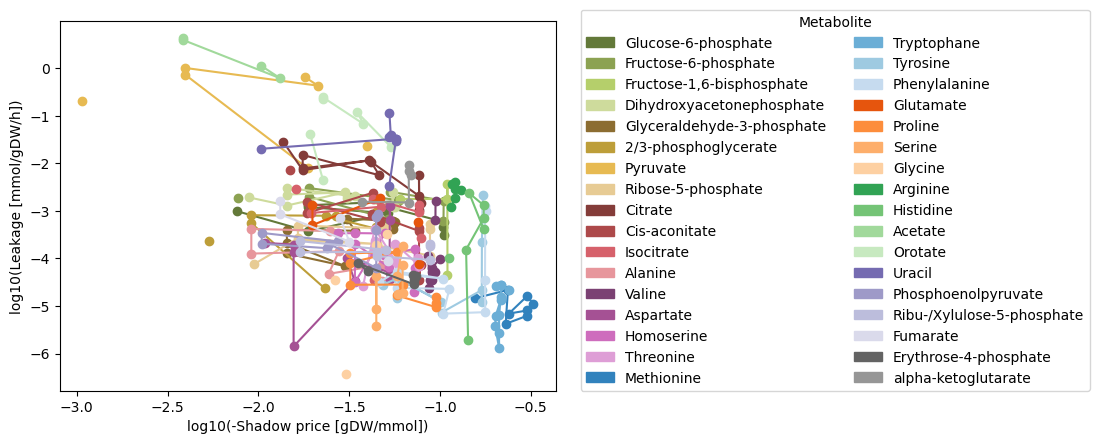

In [11]:
fig, ax = plt.subplots(1)
hours = np.arange(2.5,12.5,1)
x = 'log10(-Shadow price [gDW/mmol])'
y = 'log10(Leakage [mmol/gDW/h])'
# corr = []
mnames = df.loc[df.Time.isin(hours), 'Metabolite name'].unique()

for j, m in enumerate(mnames):
    dfm = df.loc[df['Metabolite name']==m,:]
    ax.plot(dfm[x], dfm[y], c = cmap40(j), marker = 'o')
    # ax.scatter(dfm[x], dfm[y], c = cmap40(j))
    # print(dfm)

patches = [mpatches.Patch(color=cmap40(k), label=mnames[k]) for k in range(len(mnames))]
l1 = plt.legend(handles=patches, ncol = 2, loc = (1.05,0), title = 'Metabolite')

plt.xlabel(x)
plt.ylabel(y)

# Normalize by carbon uptake

In [12]:
df['Glc-normalized leakage'] = df['Leakage (mmol/gDW/h)']/df['Glucose']

In [13]:
df['log10(glc-normalized leakage)'] = np.log10(df['Glc-normalized leakage'])

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='log10(-Shadow price [gDW/mmol])', ylabel='log10(glc-normalized leakage)'>

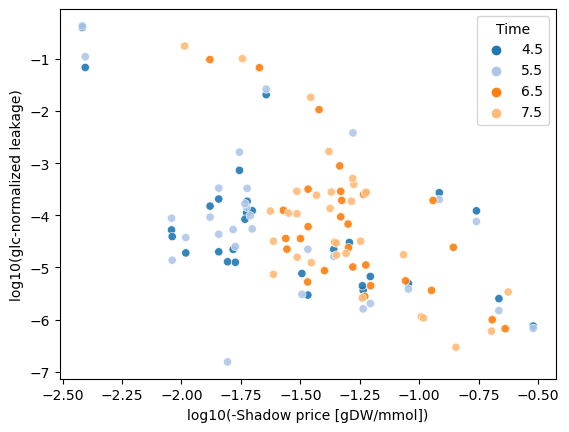

In [14]:
sns.scatterplot(data = df.loc[df.Time.isin([4.5, 5.5, 6.5, 7.5]),:], x = 'log10(-Shadow price [gDW/mmol])', y = 'log10(glc-normalized leakage)', hue = 'Time', palette = 'tab20', alpha = 0.9)
# sns.scatterplot(data = df, x = 'Low log10(-Shadow price)', y = 'log10(Leakage [mmol/gDW/h])', hue = 'Time', palette = 'tab20', alpha = 0.9)

<Axes: xlabel='log10(-Shadow price [gDW/mmol])', ylabel='log10(Leakage [mmol/gDW/h])'>

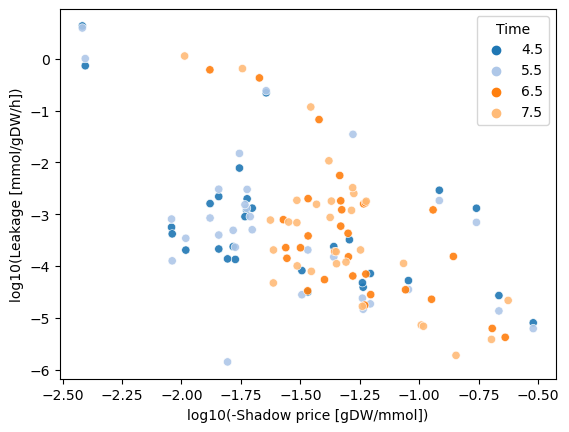

In [15]:
sns.scatterplot(data = df.loc[df.Time.isin([4.5, 5.5, 6.5, 7.5]),:], x = 'log10(-Shadow price [gDW/mmol])', y = 'log10(Leakage [mmol/gDW/h])', hue = 'Time', palette = 'tab20', alpha = 0.9)


/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_15963/1163834372.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['Glucose'] = [np.round(x,2) for x in dft['Glucose']]


<Axes: xlabel='Glucose', ylabel='log10(Leakage [mmol/gDW/h])'>

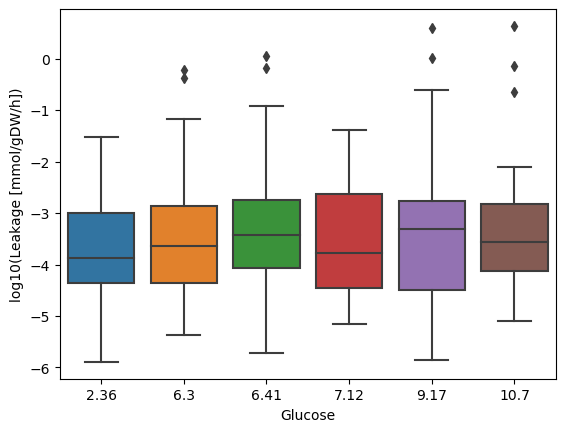

In [16]:
timepoints2 = [3.5, 4.5, 5.5, 6.5, 7.5, 8.5]
dft = df.loc[df.Time.isin(timepoints2),:]
dft['Glucose'] = [np.round(x,2) for x in dft['Glucose']]
sns.boxplot(data = dft, x = 'Glucose', y = 'log10(Leakage [mmol/gDW/h])')

Glucose-6-phosphate 0.5596983689753674 0.24811863571351134
Fructose-6-phosphate 0.31782819718338856 0.5393103742195724
Dihydroxyacetonephosphate 0.77738433092584 0.06882043988422311
2/3-phosphoglycerate 0.19505967444512956 0.71112133055518
Phosphoenolpyruvate 0.7183453613213839 0.10782226557186254
Ribose-5-phosphate 0.47482496496235227 0.3412892734622875
Ribu-/Xylulose-5-phosphate 0.5884532856408162 0.2192040699939043
Citrate 0.6449190816696821 0.16673895025762958
Cis-aconitate 0.39836072063372374 0.43406710214104666
Fumarate 0.8976201556799193 0.10237984432008074
Alanine 0.6081666335806504 0.20022032860855038
Valine -0.1263374147870782 0.8115021225517409
Aspartate 0.2876289652455085 0.6388936172691825
Threonine 0.6819849431569018 0.13561936454793458
Methionine -0.421344792280168 0.4053837841668405
Tryptophane 0.7447952054485413 0.08938355204786173
Tyrosine 0.3738554477986557 0.535325821522829
Phenylalanine 0.765033811706488 0.07632752743603956
Glutamate 0.20751121897600805 0.792488781

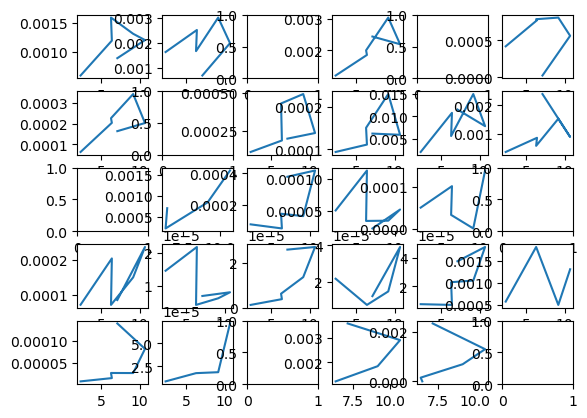

In [17]:
n = len(dft['Metabolite name'].unique())
fig, axes = plt.subplots(5,6)
axes = axes.flatten()
for i, m in enumerate(dft['Metabolite name'].unique()):
    dfm = dft.loc[dft['Metabolite name'] == m,:]
    # corr = np.corrcoef(dfm['Leakage (mmol/gDW/h)'], dfm['Glucose'])
    dfx = dfm.dropna()
    if len(dfx) > 2:
        rho, pval = st.pearsonr(dfx['Leakage (mmol/gDW/h)'], dfx['Glucose'])
        print(m, rho, pval)
        axes[i].plot(dfx['Glucose'], dfx['Leakage (mmol/gDW/h)'])
        

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4575: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


<Axes: xlabel='log10(glc-normalized leakage)', ylabel='Metabolite name'>

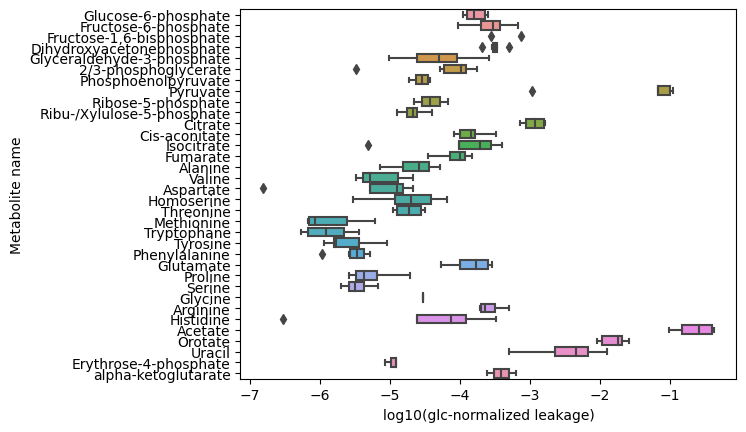

In [18]:
dft = df.loc[df.Time.isin(timepoints2),:]
sns.boxplot(data = dft, y = 'Metabolite name', x = 'log10(glc-normalized leakage)')

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4575: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


<Axes: xlabel='log10(Leakage [mmol/gDW/h])', ylabel='Metabolite name'>

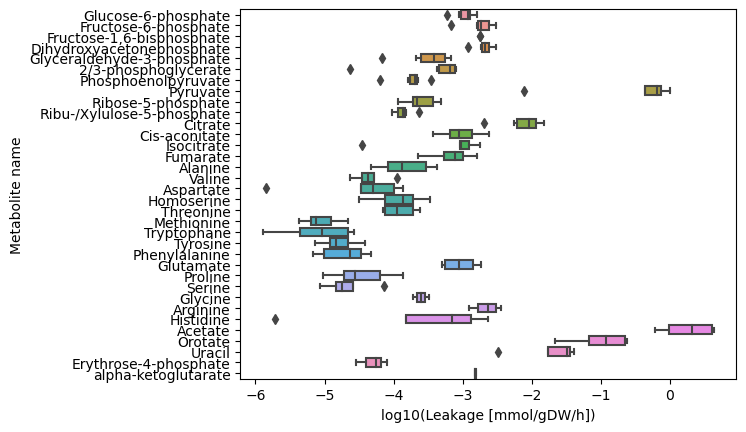

In [19]:
dft = df.loc[df.Time.isin(timepoints2),:]
sns.boxplot(data = dft, y = 'Metabolite name', x = 'log10(Leakage [mmol/gDW/h])')

In [20]:
# dft.groupby('Metabolite name').std()/dft.groupby('Metabolite name').mean()

# Histogram of release rates

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


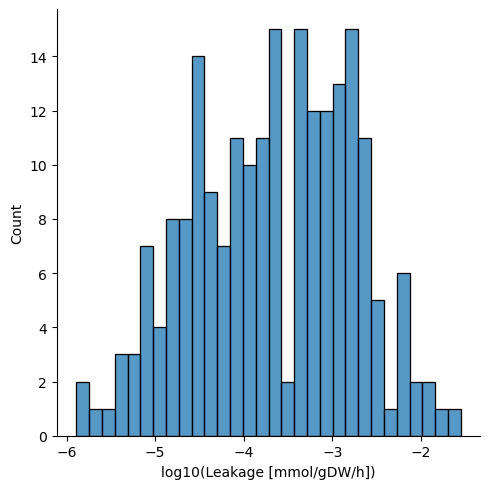

In [21]:
dffff = df.reset_index().dropna()
sns.displot(data = dffff, x = 'log10(Leakage [mmol/gDW/h])', bins = 30)#, hue = 'Time', fill = False)#histplot
# sns.ecdfplot(data = dffff, x = 'log10(Leakage [mmol/gDW/h])')#, hue = 'Time', fill = False)#histplot)

In [22]:
dist = st.norm
fit = st.fit(dist, dffff['log10(Leakage [mmol/gDW/h])'], bounds=[[-6, -2], [0, 4]])

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)


<Axes: title={'center': 'Fitted $\\tt norm$ PDF and Histogram'}, xlabel='x', ylabel='PDF'>

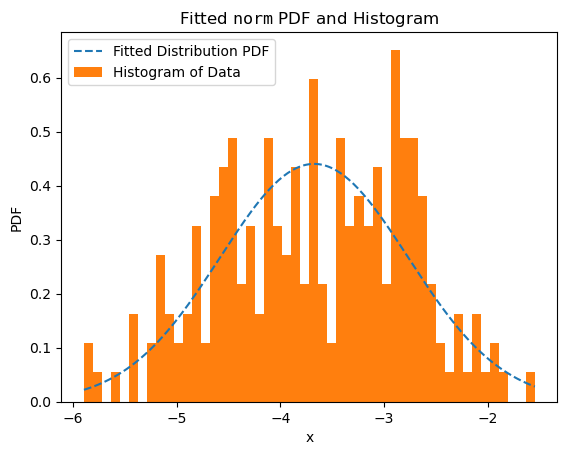

In [23]:
fit.plot()

In [24]:
res = st.normaltest(dffff['log10(Leakage [mmol/gDW/h])'])
print(res)

NormaltestResult(statistic=10.071990563322277, pvalue=0.0064997258385081965)


<Axes: xlabel='log10(Leakage [mmol/gDW/h])', ylabel='Count'>

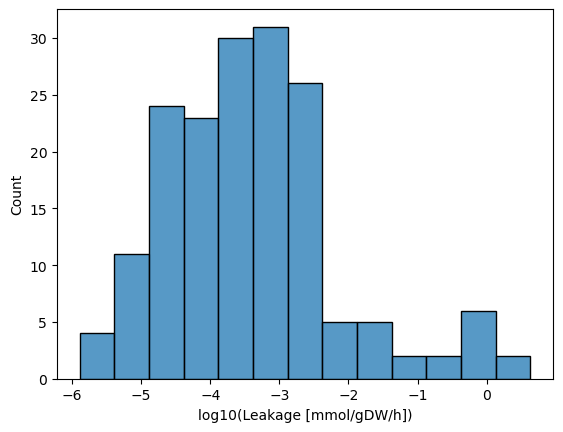

In [25]:
dffff = dft.reset_index()
sns.histplot(data = dffff, x = 'log10(Leakage [mmol/gDW/h])')#, hue = 'Time', fill = False)

4.5 Fructose-1,6-bisphosphate
4.5 Isocitrate
4.5 Uracil
5.5 Fructose-1,6-bisphosphate
5.5 Glycine
6.5 Fructose-1,6-bisphosphate
6.5 Tyrosine
6.5 Uracil
7.5 Glutamate
7.5 Serine
7.5 Glycine
7.5 Arginine


Text(0.99, 0.9, 'Spearman ρ = -0.50, p-value = 6.71e-09')

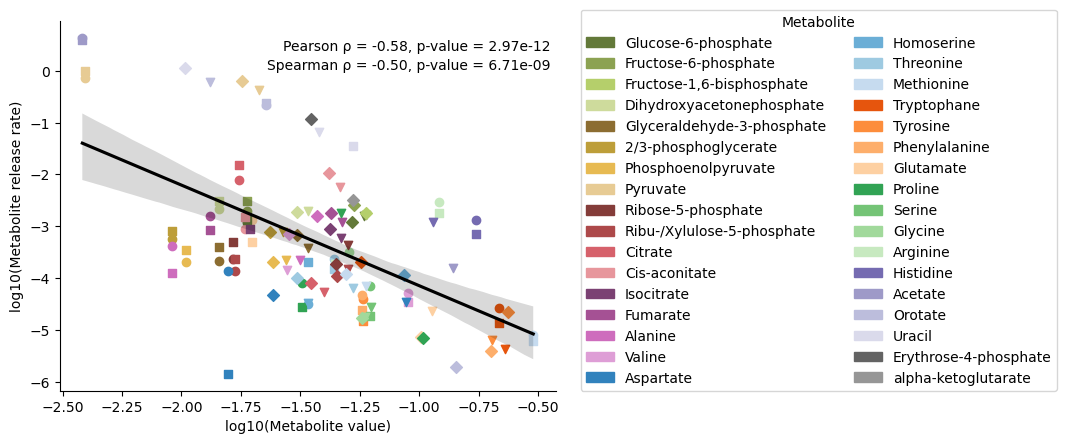

In [26]:
fig, ax = plt.subplots(1)#, figsize = (20,6))
# plt.subplots_adjust(right=0.4)
hours = [4.5, 5.5, 6.5, 7.5]
hours_string = ['4 - 5', '5 - 6', '6 - 7', '7 - 8']
x = 'Shadow price [gDW/mmol]'
x = 'log10(-Shadow price [gDW/mmol])'
# x = 'Median log10(-Shadow price)'
y = 'log10(Leakage [mmol/gDW/h])'
symbols = ['o', 's', 'v', 'D']
corr = []
all_xy = []
mnames = df.loc[df.Time.isin(hours), 'Metabolite name'].unique()

for i, t in enumerate(hours):
    x_arr = df.loc[df.Time==t, x]
    y_arr = df.loc[df.Time==t, y]
    l_arr = df.loc[df.Time==t, 'Metabolite name']
    xy_corr = []
    for j, (xj,yj) in enumerate(zip(x_arr, y_arr)):
        if not np.isnan(yj) and not np.isnan(xj):
            xy_corr.append([xj,yj])
            ax.scatter(xj, yj, marker = symbols[i], color = cmap40(j), label = l_arr[j])
        else:
            print(t, l_arr[j])
    all_xy += xy_corr
    corr.append(st.pearsonr([x[0] for x in xy_corr],[x[1] for x in xy_corr]))
patches = [mpatches.Patch(color=cmap40(k), label=mnames[k]) for k in range(len(mnames))]
patches2 = [mlines.Line2D([], [], color='k', marker=m, linestyle='None',
                          markersize=8, label=t) for m,t in zip(symbols, hours_string)]
l1 = plt.legend(handles=patches, ncol = 2, loc = (1.05,0), title = 'Metabolite')
# plt.legend(handles=patches2, ncol = 5, loc = (0,1.05), title = 'Time deltas [h]')
# ax.add_artist(l1)
# all_x_arr = [x[0] for x in all_xy]
# all_y_arr = [x[1] for y in all_xy]
all_x_arr = df.loc[df.Time.isin(hours), x]
all_y_arr = df.loc[df.Time.isin(hours), y]
sns.regplot(x=all_x_arr, y = all_y_arr, ax = ax, scatter = False, color = 'k', ci = 95)
plt.xlabel('log10(Metabolite value)')
plt.ylabel('log10(Metabolite release rate)')
sns.despine()
prho, ppval = st.pearsonr([x[0] for x in all_xy],[x[1] for x in all_xy])
srho, spval = st.spearmanr([x[0] for x in all_xy],[x[1] for x in all_xy])

ax.text(0.99, 0.95, 'Pearson ρ = {0:.2f}, p-value = {1:.2e}'.format(prho, ppval),
     horizontalalignment='right',
     verticalalignment='top',
     transform = ax.transAxes)
ax.text(0.99, 0.9, 'Spearman ρ = {0:.2f}, p-value = {1:.2e}'.format(srho, spval),
     horizontalalignment='right',
     verticalalignment='top',
     transform = ax.transAxes)
# plt.tight_layout()


In [32]:
np.polyfit([x[0] for x in all_xy],[x[1] for x in all_xy], 1)

array([-1.94204311, -6.08989226])

In [33]:
-6+-1.5*-1.94

-3.09

In [28]:
corr

[PearsonRResult(statistic=-0.6005656783262568, pvalue=0.000571937570848496),
 PearsonRResult(statistic=-0.5428468869449152, pvalue=0.0019382542253014966),
 PearsonRResult(statistic=-0.6380910153314655, pvalue=0.00014846535817800762),
 PearsonRResult(statistic=-0.7114538866202816, pvalue=1.0453862693669664e-05)]

# Correlations between lekage rates and chosen parameters

In [19]:
df.columns

Index(['Metabolite name', 'Metabolite id', 'Mass', 'Charge', 'Phosphate',
       'Topological Polar Surface Area []', 'Concentration', 'log P',
       'Leakage (mmol/gDW/h)', 'Time', 'Glucose', 'Predicted growth rate',
       'Shadow price', 'Turnover', 'Median log10(-Shadow price)',
       'Low log10(-Shadow price)', 'High log10(-Shadow price)',
       'Uptake (mmol/gDW/h)', 'log10(Leakage [mmol/gDW/h])',
       'log10(-Shadow price [gDW/mmol)', 'log10(Turnover [mmol/gDW/h])',
       'Shadow price [gDW/mmol]', 'Topological Polar Surface Area [Å]'],
      dtype='object')

4.5 Fructose-1,6-bisphosphate
4.5 Isocitrate
4.5 Uracil
5.5 Fructose-1,6-bisphosphate
5.5 Glycine
6.5 Fructose-1,6-bisphosphate
6.5 Tyrosine
6.5 Uracil
7.5 Glutamate
7.5 Serine
7.5 Glycine
7.5 Arginine


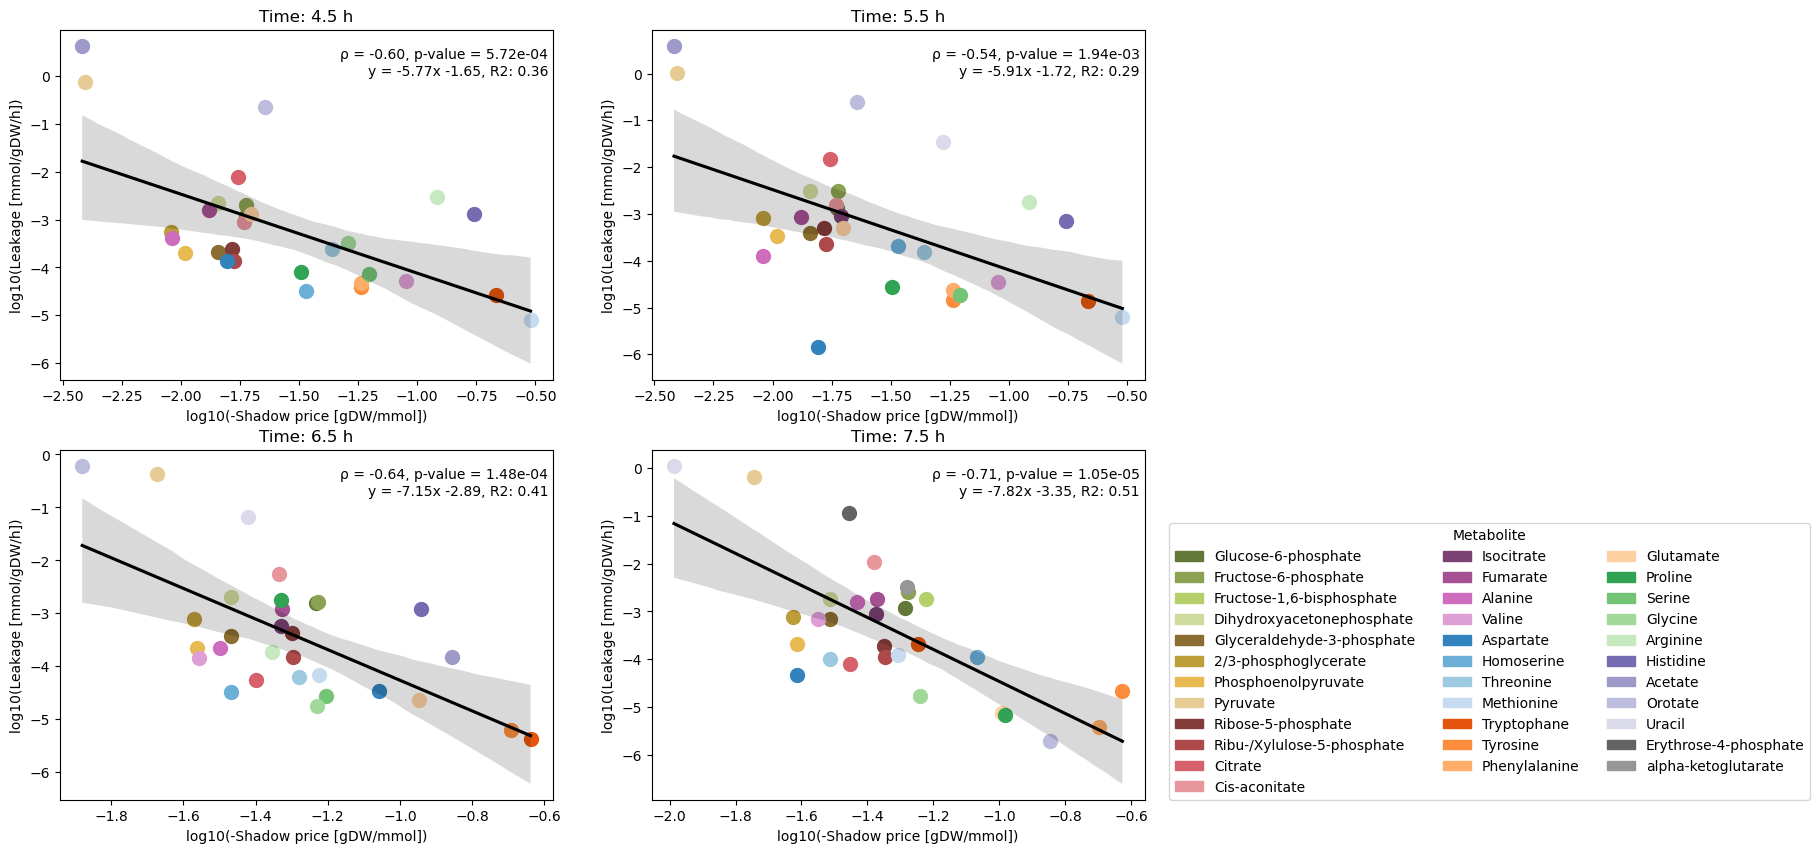

In [159]:


# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize = (14, 10))
ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
ax3 = fig.add_subplot(gs[1, 0]) # row 1, span all columns
ax4 = fig.add_subplot(gs[1, 1]) # row 1, span all columns

axes = [ax1,ax2,ax3, ax4]
# fig, axes = plt.subplots(2,2, )
# axes = axes.flatten()
hours = [4.5, 5.5, 6.5, 7.5]
# x = 'log10(Turnover)'
x = 'log10(-Shadow price [gDW/mmol])'
y = 'log10(Leakage [mmol/gDW/h])'
symbols = ['o', 's', 'v', 'D']
corr = []
mnames = df.loc[df.Time.isin(hours), 'Metabolite name'].unique()
for i, t in enumerate(hours):
    x_arr = df.loc[df.Time==t, x]
    y_arr = df.loc[df.Time==t, y]
    l_arr = df.loc[df.Time==t, 'Metabolite name']
    xy_corr = []
    for j, (xj,yj) in enumerate(zip(x_arr, y_arr)):
        if not np.isnan(yj) and not np.isnan(xj):
            xy_corr.append([xj,yj])
            axes[i].scatter(xj, yj, color = cmap40(j), label = l_arr[j], s = 100)#marker = symbols[i]
        else:
            print(t, l_arr[j])
    rho, pval = st.pearsonr([x[0] for x in xy_corr],[x[1] for x in xy_corr])
    corr.append((rho, pval))
    
    axes[i].text(0.99, 0.95, 'ρ = {0:.2f}, p-value = {1:.2e}'.format(rho, pval),
     horizontalalignment='right',
     verticalalignment='top',
     transform = axes[i].transAxes)
    axes[i].set_title('Time: {0} h'.format(t))
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(y)
    sns.regplot(x=x_arr, y = y_arr, ax = axes[i], scatter = False, color = 'k', ci = 95)
    
    X = sm.add_constant([xy[0] for xy in xy_corr])
    model = sm.OLS([xy[1] for xy in xy_corr], X)
    res = model.fit()
    # print(res.summary())
    axes[i].text(0.99, 0.9, 'y = {0:.2f}x {1:0.2f}, R2: {2:.2f}'.format(res.params[0], res.params[1], res.rsquared),
     horizontalalignment='right', verticalalignment='top', transform = axes[i].transAxes)
    
patches = [mpatches.Patch(color=cmap40(k), label=mnames[k]) for k in range(len(mnames))]
# patches2 = [mlines.Line2D([], [], color='k', marker=m, linestyle='None',
                          # markersize=8, label=t) for m,t in zip(symbols, hours)]
l1 = plt.legend(handles=patches, ncol = 3, loc = (1.05,0), title = 'Metabolite')
# plt.legend(handles=patches2, ncol = 23, loc = (0,1.05), title = 'Time [h]')
# plt.gca().add_artist(l1)

# plt.xlabel(x)
# plt.ylabel(y)
# plt.tight_layout()

6.5 Fructose-1,6-bisphosphate
6.5 Uracil
7.5 alpha-ketoglutarate
7.5 Glutamate
8.5 Pyruvate
8.5 Erythrose-4-phosphate
8.5 Fumarate
8.5 Arginine


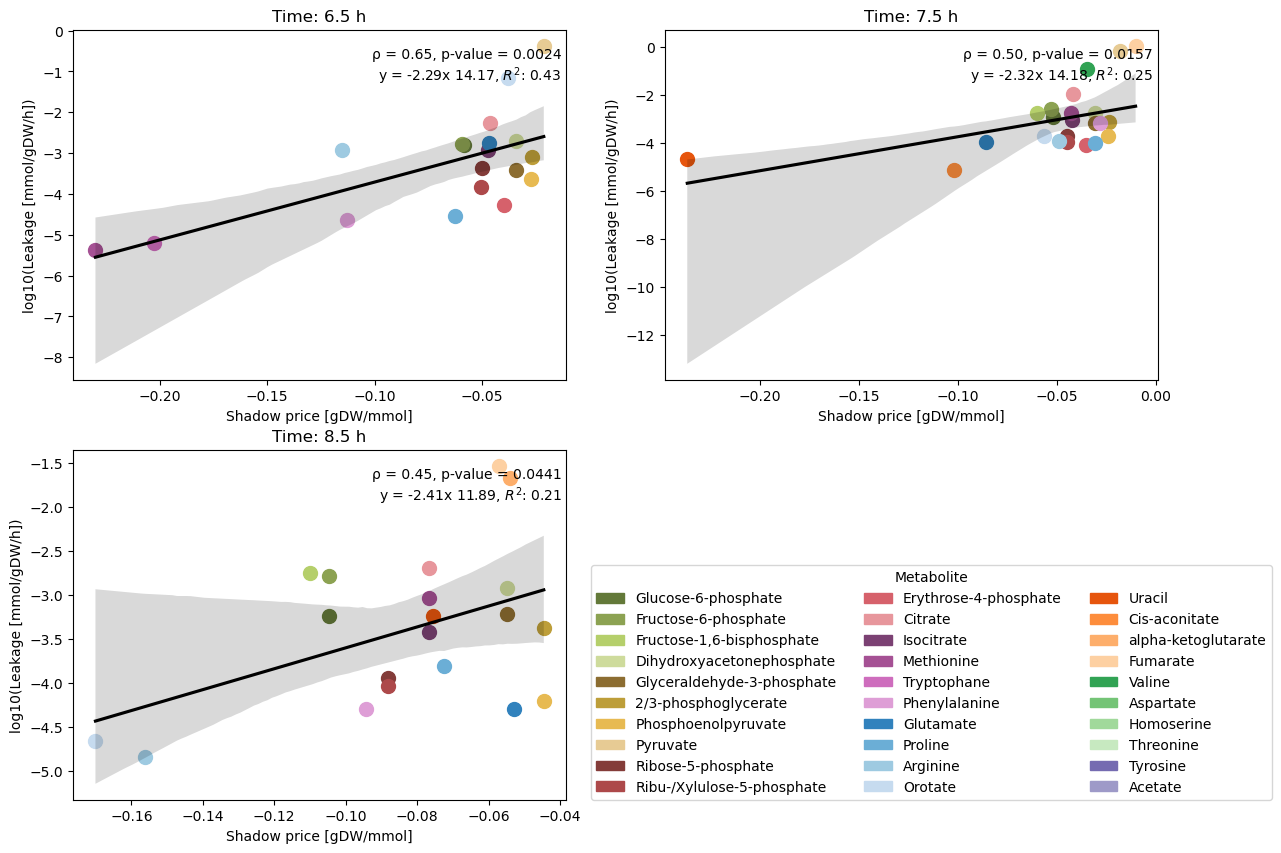

In [50]:
import matplotlib.gridspec as gridspec
import statsmodels.api as sm

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize = (14, 10))
ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
ax3 = fig.add_subplot(gs[1, 0]) # row 1, span all columns
axes = [ax1,ax2,ax3]
# fig, axes = plt.subplots(2,2, )
# axes = axes.flatten()
hours = [6.5, 7.5, 8.5]
x = 'Shadow price [gDW/mmol]'
# x = 'Charge'
# x = 'log10(Turnover)'
y = 'log10(Leakage [mmol/gDW/h])'
symbols = ['o', 's', 'v', 'D']
corr = []
mnames = df.loc[df.Time.isin(hours), 'Metabolite name'].unique()
for i, t in enumerate(hours):
    x_arr = df.loc[df.Time==t, x]
    y_arr = df.loc[df.Time==t, y]
    l_arr = df.loc[df.Time==t, 'Metabolite name']
    xy_corr = []
    for j, (xj,yj) in enumerate(zip(x_arr, y_arr)):
        if not np.isnan(yj) and not np.isnan(xj):
            xy_corr.append([xj,yj])
            axes[i].scatter(xj, yj, color = cmap40(j), label = l_arr[j], s = 100)#marker = symbols[i]
        else:
            print(t, l_arr[j])
    rho, pval = st.pearsonr([x[0] for x in xy_corr],[x[1] for x in xy_corr])
    corr.append((rho, pval))
    
    axes[i].text(0.99, 0.95, 'ρ = {0:.2f}, p-value = {1:.4f}'.format(rho, pval),
     horizontalalignment='right',
     verticalalignment='top',
     transform = axes[i].transAxes)
    axes[i].set_title('Time: {0} h'.format(t))
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(y)
    sns.regplot(x=x_arr, y = y_arr, ax = axes[i], scatter = False, color = 'k', ci = 95)
    
    X = sm.add_constant([xy[0] for xy in xy_corr])
    model = sm.OLS([xy[1] for xy in xy_corr], X)
    res = model.fit()
    # print(res.summary())
    axes[i].text(0.99, 0.9, 'y = {0:.2f}x {1:0.2f}, $R^2$: {2:.2f}'.format(res.params[0], res.params[1], res.rsquared),
     horizontalalignment='right', verticalalignment='top', transform = axes[i].transAxes)
    
patches = [mpatches.Patch(color=cmap40(k), label=mnames[k]) for k in range(len(mnames))]
# patches2 = [mlines.Line2D([], [], color='k', marker=m, linestyle='None',
                          # markersize=8, label=t) for m,t in zip(symbols, hours)]
l1 = plt.legend(handles=patches, ncol = 3, loc = (1.05,0), title = 'Metabolite')
# plt.legend(handles=patches2, ncol = 23, loc = (0,1.05), title = 'Time [h]')
# plt.gca().add_artist(l1)

# plt.xlabel(x)
# plt.ylabel(y)
# plt.tight_layout()

# All correlations

In [135]:
cols_for_corr = ['Mass',
       'Charge', 'Phosphate', 'Topological Polar Surface Area [Å]',
       # 'Concentration', 
       # 'Shadow price [gDW/mmol]',
                 'log10(-Shadow price [gDW/mmol])',
       'log10(Turnover [mmol/gDW/h])', 'log P'] #'Median log10(-Shadow price)',
       # 'Low log10(-Shadow price)', 'High log10(-Shadow price)']


In [136]:
cols_for_corr

['Mass',
 'Charge',
 'Phosphate',
 'Topological Polar Surface Area [Å]',
 'log10(-Shadow price [gDW/mmol])',
 'log10(Turnover [mmol/gDW/h])',
 'log P']

## "timecourse" for correlations for all parameters

Mass
Charge
Phosphate
Topological Polar Surface Area [Å]
log10(-Shadow price [gDW/mmol])
log10(Turnover [mmol/gDW/h])
log P


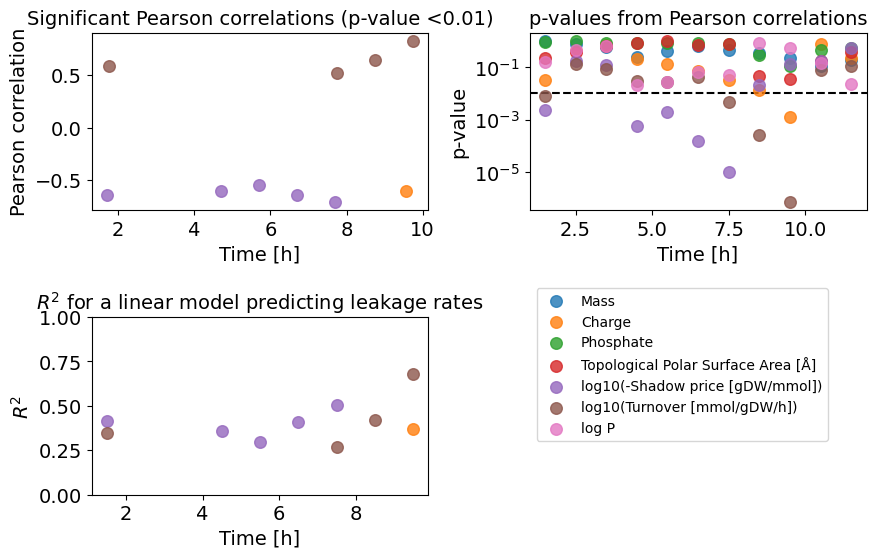

In [137]:
# Create 2x2 sub plots
fig, axes = plt.subplots(2,2, figsize = (10,6))
[ax1,ax2,ax3, ax4] = axes.flatten()
hours = df.Time.unique()
y = 'log10(Leakage [mmol/gDW/h])'

pval_lim = 0.01
for i, c in enumerate(cols_for_corr):
    corr = []
    print(c)
    pvals = np.zeros(len(hours))
    rhos = np.zeros(len(hours))
    r2s = np.zeros(len(hours))
    for k, h in enumerate(hours):
        dft = df.loc[df.Time==h, [c, y]]
        x_arr = dft[c]
        y_arr = dft[y]
        
        xc = []
        yc = []
        for j, (xj,yj) in enumerate(zip(x_arr, y_arr)):
            if np.isfinite(yj) and np.isfinite(xj):
                xc.append(xj)
                yc.append(yj)
                
        rho, pvals[k] = st.pearsonr(xc,yc)
        X = sm.add_constant(xc)
        model = sm.OLS(yc, X)
        res = model.fit()
        
        if pvals[k] < pval_lim:
            rhos[k] = rho
            r2s[k] = res.rsquared
        else:
            rhos[k] = np.nan
            r2s[k] = np.nan
            
            
    ax1.scatter(hours+0.05*i, rhos, label = c, s = 70, alpha = 0.8)
    ax2.scatter(hours, pvals,label = c, s = 70, alpha = 0.8)
    ax3.scatter(hours, r2s, label = c, s = 70, alpha = 0.8)
    
ax2.axhline(pval_lim, c = 'k', ls = '--', zorder = -1)
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('Time [h]', fontdict = {'size':14})
    ax.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylabel('Pearson correlation', fontdict = {'size':14})
ax2.set_yscale('log')
ax2.set_ylabel('p-value', fontdict = {'size':14})
ax3.set_ylabel('$R^2$', fontdict = {'size':14})
ax3.set_ylim(0,1)
ax2.legend(loc='upper left', bbox_to_anchor=(0., -0.4), ncol = 1)
ax2.set_title('p-values from Pearson correlations', fontdict = {'size':14})
ax1.set_title('Significant Pearson correlations (p-value <{0})'.format(pval_lim), fontdict = {'size':14})
ax3.set_title('$R^2$ for a linear model predicting leakage rates', fontdict = {'size':14})
ax4.set_axis_off()

plt.subplots_adjust(hspace = 0.6, wspace = 0.3)
# patches = [mpatches.Patch(color=cmap40(k), label=mnames[k]) for k in range(len(mnames))]
# # patches2 = [mlines.Line2D([], [], color='k', marker=m, linestyle='None',
#                           # markersize=8, label=t) for m,t in zip(symbols, hours)]
# l1 = axes[N-1].legend(handles=patches, ncol = 3, loc = (1.05,0), title = 'Metabolite')
# plt.tight_layout()

In [596]:
df.columns

Index(['Metabolite name', 'Metabolite id', 'Mass', 'Charge', 'Phosphate',
       'Topological Polar Surface Area []', 'Concentration', 'log P',
       'Leakage (mM/gDW/h)', 'Time', 'Glucose', 'Predicted growth rate',
       'Shadow price', 'Turnover', 'Uptake (mM/gDW/h)', 'log10(leakage)',
       'log10(-Shadow price)', 'log10(Turnover)',
       'log10(leakage [mmol/gDW/h])', 'Shadow price [gDW/mmol]',
       'Topological Polar Surface Area [Å]'],
      dtype='object')

IndexError: list index out of range

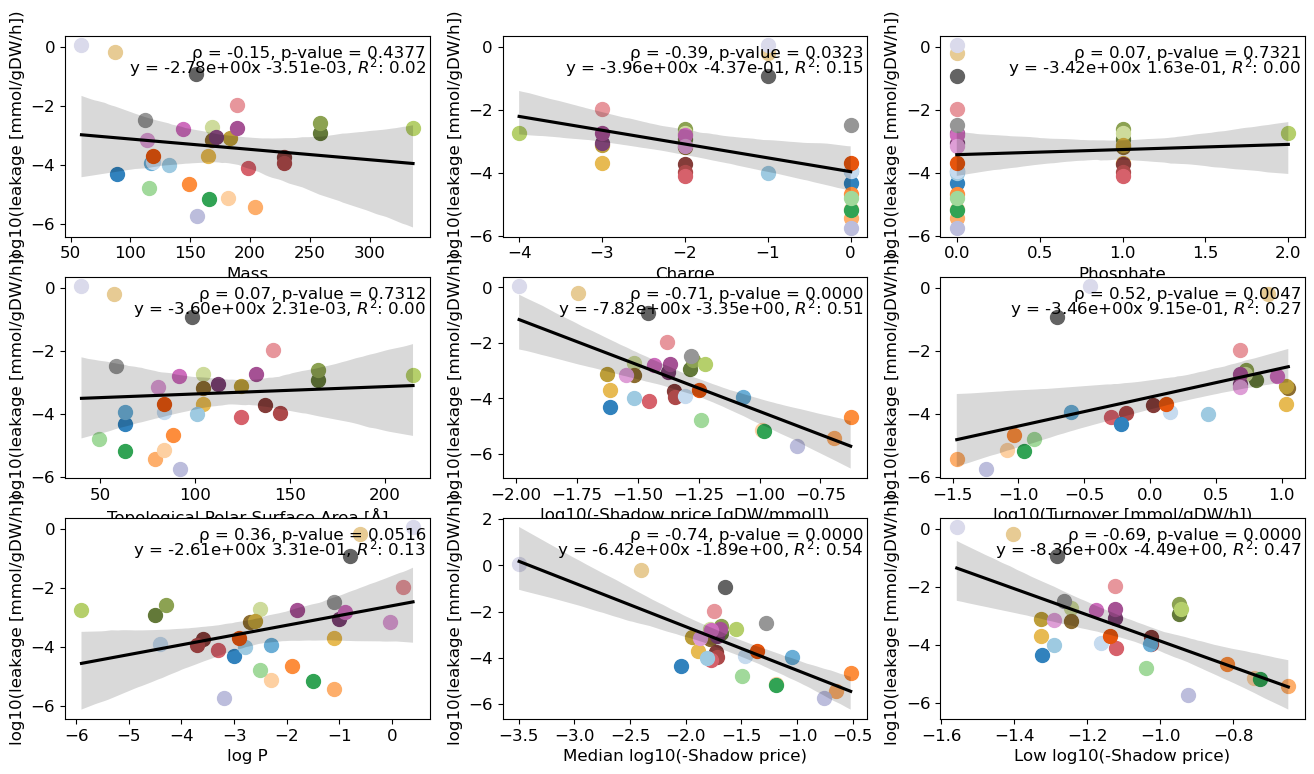

In [26]:
# Create 2x2 sub plots
N = len(cols_for_corr)
gs = gridspec.GridSpec(4, 3)
fig = plt.figure(figsize = (16, 12))
axes = []
l = 0 
for i in range(3):
    for j in range(3):
        if i*3+j >=N:
            break
        axes.append(fig.add_subplot(gs[i, j])) # row 0, col 0
dft = df.loc[df.Time==7.5, cols_for_corr+['Metabolite name', 'log10(Leakage [mmol/gDW/h])']]
# dft = dft0.loc[~dft0.isna().any(axis =1),:]
l_arr = dft['Metabolite name'].unique()
y_arr = dft['log10(Leakage [mmol/gDW/h])']

corr = []
for i, c in enumerate(cols_for_corr):
    ax = axes[i]
    x_arr = dft[c]
    xy_corr = []
    for j, (xj,yj) in enumerate(zip(x_arr, y_arr)):
        if np.isfinite(yj) and np.isfinite(xj):
            xy_corr.append([xj,yj])
        ax.scatter(xj, yj, color = cmap40(j), label = l_arr[j], s = 100)#marker = symbols[i]
    xc = [x[0] for x in xy_corr]
    yc = [x[1] for x in xy_corr]
    # print(xc, yc)
    rho, pval = st.pearsonr(xc,yc)
    # rho, pval = st.pearsonr(x_arr, y_arr)
    corr.append((rho, pval))
    
    axes[i].text(0.99, 0.95, 'ρ = {0:.2f}, p-value = {1:.4f}'.format(rho, pval),
     horizontalalignment='right',
     verticalalignment='top',
     transform = axes[i].transAxes,  fontdict={'size': 12})
    sns.regplot(x=xc, y = yc, ax = axes[i], scatter = False, color = 'k', ci = 95)
    
    X = sm.add_constant(xc)
    model = sm.OLS(yc, X)
    res = model.fit()
    # print(res.summary())
    axes[i].text(0.99, 0.9, r'y = {0:.2e}x {1:0.2e}, $R^2$: {2:.2f}'.format(res.params[0], res.params[1], res.rsquared),
     horizontalalignment='right', verticalalignment='top', transform = axes[i].transAxes, fontdict={'size': 12})
    
    ax.set_xlabel(c,  fontdict={'size': 12})
    ax.set_ylabel('log10(leakage [mmol/gDW/h])',  fontdict={'size': 12})
    ax.tick_params(axis='both', which='major', labelsize=12)
patches = [mpatches.Patch(color=cmap40(k), label=mnames[k]) for k in range(len(mnames))]
# patches2 = [mlines.Line2D([], [], color='k', marker=m, linestyle='None',
                          # markersize=8, label=t) for m,t in zip(symbols, hours)]
l1 = axes[N-1].legend(handles=patches, ncol = 3, loc = (1.05,0), title = 'Metabolite')
# plt.tight_layout()

In [1]:
# Create 2x2 sub plots
N = len(cols_for_corr)
gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize = (16, 12))
axes = []
l = 0 
for i in range(3):
    for j in range(3):
        if i*3+j >=N:
            break
        axes.append(fig.add_subplot(gs[i, j])) # row 0, col 0
dft = df.loc[df.Time.isin([5.5, 6.5, 7.5, 8.5, 9.5, 10.5]), cols_for_corr+['Metabolite name', 'log10(leakage [mmol/gDW/h])']]
# dft = dft0.loc[~dft0.isna().any(axis =1),:]
l_arr = list(dft['Metabolite name'])
y_arr = dft['log10(leakage [mmol/gDW/h])']

corr = []
for i, c in enumerate(cols_for_corr):
    ax = axes[i]
    x_arr = dft[c]
    xy_corr = []
    for j, (xj,yj) in enumerate(zip(x_arr, y_arr)):
        if np.isfinite(yj) and np.isfinite(xj):
            xy_corr.append([xj,yj])
            # print(l_arr[j])
            ax.scatter(xj, yj, color = cmap40(j), label = l_arr[j], s = 100)#marker = symbols[i]
    xc = [x[0] for x in xy_corr]
    yc = [x[1] for x in xy_corr]
    
    rho, pval = st.pearsonr(xc,yc)
    # rho, pval = st.pearsonr(x_arr, y_arr)
    corr.append((rho, pval))
    
    axes[i].text(0.99, 0.95, 'ρ = {0:.2f}, p-value = {1:.4f}'.format(rho, pval),
     horizontalalignment='right',
     verticalalignment='top',
     transform = axes[i].transAxes)
    sns.regplot(x=x_arr, y = y_arr, ax = axes[i], scatter = False, color = 'k', ci = 95)
    
    X = sm.add_constant(xc)
    model = sm.OLS(yc, X)
    res = model.fit()
    # print(res.summary())
    axes[i].text(0.99, 0.9, r'y = {0:.2e}x {1:0.2e}, $R^2$: {2:.2f}'.format(res.params[0], res.params[1], res.rsquared),
     horizontalalignment='right', verticalalignment='top', transform = axes[i].transAxes)
    
    ax.set_xlabel(c)
    ax.set_ylabel('log10(leakage [mmol/gDW/h])')
    
patches = [mpatches.Patch(color=cmap40(k), label=mnames[k]) for k in range(len(mnames))]
# patches2 = [mlines.Line2D([], [], color='k', marker=m, linestyle='None',
                          # markersize=8, label=t) for m,t in zip(symbols, hours)]
l1 = axes[N-1].legend(handles=patches, ncol = 3, loc = (1.05,0), title = 'Metabolite')
# plt.tight_layout()

NameError: name 'cols_for_corr' is not defined

In [54]:
dft = df.loc[df.Time.isin([6.5]), cols_for_corr+['Metabolite name', 'log10(Leakage [mmol/gDW/h])']]
dfc = dft[cols_for_corr+['log10(Leakage [mmol/gDW/h])']]
# P = [organic]/[aqueous])
rho = dfc.corr()
pval = dfc.corr(method=lambda x, y: st.pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

,Mass,Charge,Phosphate,Topological Polar Surface Area [Å],log10(-Shadow price [gDW/mmol]),log10(Turnover [mmol/gDW/h]),log P,Median log10(-Shadow price),Low log10(-Shadow price),High log10(-Shadow price),log10(Leakage [mmol/gDW/h])
Mass,1.0***,-0.56**,0.73***,0.91***,0.16,0.14,-0.69***,0.02,0.42,0.02,-0.18
Charge,-0.56**,1.0***,-0.7***,-0.68***,0.69**,-0.8***,0.21,0.62**,0.35,0.62**,-0.29
Phosphate,0.73***,-0.7***,1.0***,0.71***,-0.44,0.57*,-0.66**,-0.37,-0.09,-0.37,-0.04
Topological Polar Surface Area [Å],0.91***,-0.68***,0.71***,1.0***,-0.14,0.45,-0.68***,-0.17,0.14,-0.17,0.17
log10(-Shadow price [gDW/mmol]),0.16,0.69**,-0.44,-0.14,1.0***,-0.8***,-0.08,0.97***,0.92***,0.97***,-0.68**
log10(Turnover [mmol/gDW/h]),0.14,-0.8***,0.57*,0.45,-0.8***,1.0***,-0.16,-0.82***,-0.7***,-0.82***,0.53*
log P,-0.69***,0.21,-0.66**,-0.68***,-0.08,-0.16,1.0***,-0.0,-0.27,-0.0,0.15
Median log10(-Shadow price),0.02,0.62**,-0.37,-0.17,0.97***,-0.82***,-0.0,1.0***,0.76***,1.0***,-0.69**
Low log10(-Shadow price),0.42,0.35,-0.09,0.14,0.92***,-0.7***,-0.27,0.76***,1.0***,0.76***,-0.69**
High log10(-Shadow price),0.02,0.62**,-0.37,-0.17,0.97***,-0.82***,-0.0,1.0***,0.76***,1.0***,-0.69**


# Get transporter info

In [331]:
df_trans = pd.read_csv('e_coli_transporters.csv', index_col=0)

In [345]:
df_trans.loc[df_trans.Membrane == 'inner',:]
dft = df.loc[df.Time.isin([5.5, 6.5, 7.5, 8.5, 9.5, 10.5]), cols_for_corr+['Metabolite name', 'log10(leakage [mmol/gDW/h])', 'Metabolite id']]
mIDs = dft['Metabolite id'].unique()

In [346]:
idx = df_trans['iML1515 metabolite ID'].isin(mIDs)*(df_trans.Membrane == 'inner')
dfT = df_trans.loc[idx,:]

In [347]:
# dfTT = dfT.loc[dfT.Direction.str.contains('Export'),:]

In [348]:
dfT['Transport type'].unique()
other_lst = ['4abut antiporter', 'agm antiporter',
       'orn antiporter', 'pi antiporter', 'succ antiporter', 'ATP-binding cassette transporter']
dfT.loc[dfT['Transport type'].isin(other_lst), 'Transport type'] = 'Other'


/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_20491/145764461.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfT.loc[dfT['Transport type'].isin(other_lst), 'Transport type'] = 'Other'


In [349]:
T_dict = {}
for mname in mIDs:
    tmp = dfT.loc[dfT['iML1515 metabolite ID'] == mname]
    if len(tmp)<3 and len(tmp)>0:
        T_dict[mname] = ", ".join(tmp['Transport type'].sort_values().unique())
    elif len(tmp)==0:
        T_dict[mname] = 'None'
    else:
        T_dict[mname] = 'Three or more different transporters'

In [350]:
dft['Transporter'] = dft['Metabolite id'].map(T_dict)
dft.sort_values(by='Transporter', inplace = True)

Text(0.5, 1.0, 'Estimated leakage rates grouped by annotated transporters')

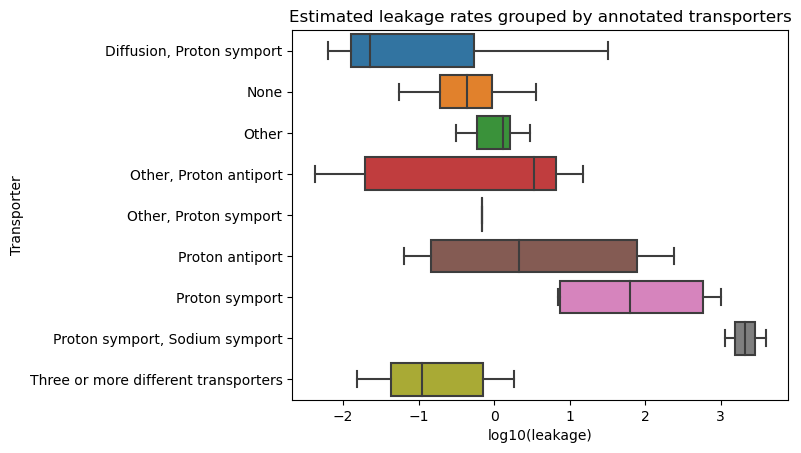

In [353]:
sns.boxplot(data = dft, x = 'log10(leakage [mmol/gDW/h])', y = 'Transporter')
# plt.legend(loc=(1.05,0))
plt.title('Estimated leakage rates grouped by annotated transporters')

# Plot a cumulative distribution of shadow prices


In [651]:
model = cobra.io.read_sbml_model('../../models/e_coli/momentiJO1366.xml')
model.solver = 'gurobi'
# model.reactions.DHAPT.knock_out()
# model.reactions.THRA.knock_out()
# model.reactions.THRA2.knock_out()
# model.reactions.F6PA_TG_forward.knock_out()
# Speculations
# model.reactions.PFL.knock_out()
#I'm more and more conviced that PFL is not active in aerobic conditions
# https://doi.org/10.1016/j.jbc.2021.101423
model.reactions.EX_glc__D_e.lower_bound = -6
solution = cobra.flux_analysis.pfba(model)
print(model.summary(solution))

Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.5732271225866007

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e  0.002984         0   0.00%
      cl_e      EX_cl_e  0.002984         0   0.00%
 cobalt2_e EX_cobalt2_e 1.433E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0004064         0   0.00%
     fe2_e     EX_fe2_e  0.009207         0   0.00%
  glc__D_e  EX_glc__D_e         6         6 100.00%
       k_e       EX_k_e    0.1119         0   0.00%
     mg2_e     EX_mg2_e  0.004973         0   0.00%
     mn2_e     EX_mn2_e 0.0003961         0   0.00%
    mobd_e    EX_mobd_e 7.395E-05         0   0.00%
     nh4_e     EX_nh4_e     6.191         0   0.00%
     ni2_e     EX_ni2_e 0.0001852         0   0.00%
      o2_e      EX_o2_e     11.25         0   0.00%
      pi_e      EX_pi_e     0.553         0   0.00%
     so4_e     EX_so4_e    0.1446         0   0.00%
     zn2_e     EX_zn2_e 0.0001955  

In [652]:
sp = leakage.estimate_shadow_prices(model, delta=0.1)
# solution = model.optimize()
# sp = solution.shadow_prices

In [653]:
Ssp = pd.Series(sp)

In [654]:
solution = cobra.flux_analysis.pfba(model)
# solution = model.optimize()
turnover_dict = {}
for m in model.metabolites:
    if m.compartment == 'c':
        turnover_dict[m.id] = m.summary(solution).producing_flux['flux'].sum()

In [700]:
sp_list = []
met_ids = []
for m in model.metabolites:
    # Remove non-organic compounds
    if m.id in ['hco3_c', 'co2_c']:
        continue
    if m.compartment == 'c':
        if 'C' in m.elements.keys():
            if m.formula_weight and (m.formula_weight < 500):
                if turnover_dict[m.id] >0:
                    if 'C' in m.elements.keys():
                        if sp[m.id] < 0:
                            met_ids.append(m.id)
                            sp_list.append(sp[m.id])

/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/cobra/core/metabolite.py:191: UserWarning: The element 'R' does not appear in the periodic table
  warn(f"The element {e} does not appear in the periodic table")
/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/cobra/core/metabolite.py:191: UserWarning: The element 'X' does not appear in the periodic table
  warn(f"The element {e} does not appear in the periodic table")


In [701]:
selected_sp = pd.Series(sp_list, index = met_ids)
selected_sp.dropna(inplace = True)

In [702]:
selected_sp.sort_values(inplace = True, ascending=False)

In [703]:
model.metabolites.fdp_c

Metabolite identifier,fdp_c
Name,"D-Fructose 1,6-bisphosphate"
Memory address,0x7f97c19dc3d0
Formula,C6H10O12P2
Compartment,c
In 5 reaction(s),"PFK, FBA_TG_forward, FRUK, FBP, FBA_TG_reverse"


In [704]:
max_leak = df.loc[:, ['Metabolite name','Metabolite id', 'log10(leakage [mmol/gDW/h])']].groupby('Metabolite name').max()
smax = max_leak['log10(leakage [mmol/gDW/h])'].max()
smin = max_leak['log10(leakage [mmol/gDW/h])'].min()

In [706]:
max_leak.set_index('Metabolite id', inplace = True)

In [707]:
selected_sp.index = [m[:-2] for m in selected_sp.index]

# Data from Zampieri

In [708]:
fn_zampieri = '../../data/e_coli/zampieri_exometabolome_2019.xlsx'
df_z = pd.read_excel(fn_zampieri, sheet_name='Fitted data')

min_grad = 1e-4
min_n_grad = 1
colors = []
status = []
for i, row in df_z.iterrows():
    y = row[3:]/row[3:].max()
    if sum(y.diff() > min_grad) < min_n_grad:
        # Always consumed
        status.append('Consumed')
        colors.append('r')
    elif sum(y.diff() < -min_grad) < min_n_grad:
        status.append('Produced')
        colors.append('g')
    else:
        status.append('Mixed')
        colors.append('y')
df_zz = pd.Series(status)
consumed_df = df_z[['Metabolite name', 'Metabolite id']]
consumed_df['Status'] = df_zz
# consumed_df.to_csv('../../data/e_coli/zampieri_leakage_status.csv')
kegg_dict = {}
for m in model.metabolites:
    try:
        kegg_ids = m.annotation['kegg.compound']
    except KeyError:
        continue
    if isinstance(kegg_ids, str):
        kegg_ids = [kegg_ids]
    for k in kegg_ids:
        try:
            mets = kegg_dict[k]
        except:
            kegg_dict[k] = [m.id[:-2]]
        else:
            kegg_dict[k].append(m.id[:-2])
matched = []
matched_mets = []
for i, row in consumed_df.iterrows():
    kegg_id = row[1].strip("' ")
    try:
        mets = kegg_dict[kegg_id]
    except KeyError:
        matched.append(False)
        matched_mets.append([])
    else:
        matched.append(True)
        matched_mets.append(mets)
consumed_df['Matched'] = matched
consumed_df['Matched_mets'] = matched_mets
mm = consumed_df.loc[consumed_df.Status=='Produced', 'Matched_mets']
mmc = consumed_df.loc[consumed_df.Status=='Consumed', 'Matched_mets']
mmx = consumed_df.loc[consumed_df.Status=='Mixed', 'Matched_mets']
produced_mets = [x for l in mm for x in l]
consumed_mets = [x for l in mmc for x in l]
mixed_mets = [x for l in mmx for x in l]

/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_20491/2160609876.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumed_df['Status'] = df_zz
/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_20491/2160609876.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumed_df['Matched'] = matched
/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_20491/2160609876.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

fdp
ru5p__L
xu5p__L
ura


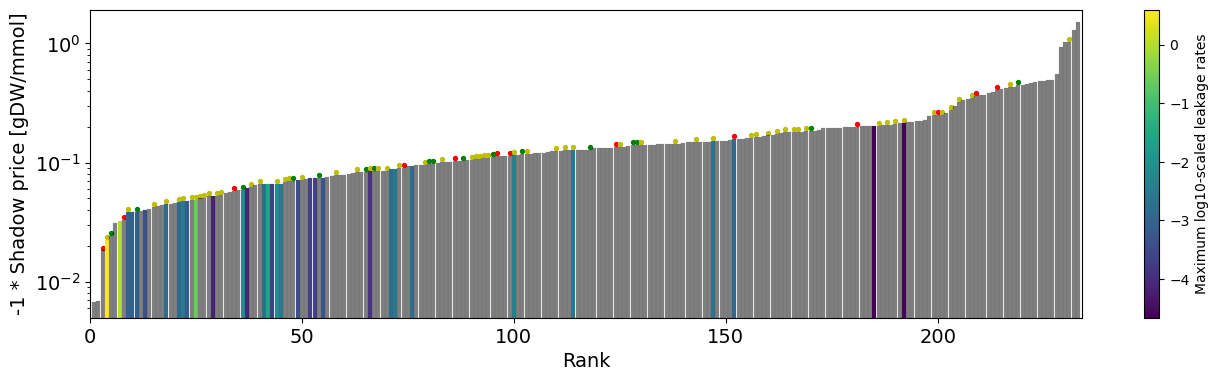

In [1087]:
# fig, [ax1, ax2] = plt.subplots(1,2, figsize = (16,6))
fig, ax = plt.subplots(1, figsize = (16,4))

norm = plt.Normalize(vmin=smin, vmax=smax)
#norm = matplotlib.colors.BoundaryNorm([0,1,2,3], cmap.N, extend='neither')
cmap = plt.cm.viridis
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

consumed_sp = []
produced_sp = []
both_sp = []
max_leak_dict = {}
for i, row in max_leak.iterrows():
    leak = row['log10(leakage [mmol/gDW/h])']
    met_ids = i.split(', ')
    for m_id in met_ids:
        try:
            met = selected_sp[m_id]
        except KeyError:
            print(m_id)
        else:
            max_leak_dict[m_id]=leak


for i, (m_id, sp_i) in enumerate(selected_sp.items()):
    try:
        leak_i = max_leak_dict[m_id]
    except KeyError:
        ax.plot([i+1,i+1], [0, -sp_i], c = 'k', alpha = 0.5, lw = 3) 
    else:
        ax.plot([i+1, i+1], [0, -sp_i], lw = 3, c = sm.to_rgba(leak_i))# colouring is wrong , lw = 2)#, cmap = cmap, norm = norm)

        
    if m_id in consumed_mets:
        ax.scatter(i+1, -sp_i*1.1, c = 'r', s = 8)
        consumed_sp.append(np.log10(-sp_i))
    elif m_id in produced_mets:
        ax.scatter(i+1, -sp_i*1.1, c = 'g', s = 8) 
        produced_sp.append(np.log10(-sp_i))
    elif m_id in mixed_mets:
        ax.scatter(i+1, -sp_i*1.1, c = 'y', s = 8)
        both_sp.append(np.log10(-sp_i))
        
    
#     # # Make a seperate plot for the 10% least expensive
#     # if i < first_x:
    #     if leak_i > 0:
    #         ax2.scatter(i, sp_abs, s = 50, c = np.log(leak_i), cmap = cmap, norm = norm)
    #     else:
    #         ax2.scatter(i, sp_abs,s=10, c = 'k', alpha = 0.5)
    #     ax2.annotate(m_id[:-2], (i+0.5, sp_abs*0.9))

    
    
#ax.scatter(np.arange(len(selected_sp)), np.abs(selected_sp), s = 10)
ax.set_yscale('log')
#ax1.set_xlim(0,400)
# ax2.set_yscale('log')
# ax2.set_xlim(0, first_x+5)
ax.set_ylabel('-1 * Shadow price [gDW/mmol]', fontdict={'size':14})
# ax2.set_ylabel('-1 * Shadow price')
ax.set_xlabel('Rank', fontdict={'size':14})
# ax2.set_xlabel('Rank')
ax.set_xlim(0, i+2)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.colorbar(sm, ax = ax, label = "Maximum log10-scaled leakage rates")
# plt.savefig('Rank of shadow price ecoli knock outs epsilon 001.png')

In [1088]:
st.ttest_ind(both_sp, consumed_sp, equal_var=False)

Ttest_indResult(statistic=-0.18811248160642585, pvalue=0.8532756743235743)

# Predict!

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, ARDRegression, BayesianRidge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn import tree
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [102]:
df.columns

Index(['Metabolite name', 'Metabolite id', 'Mass', 'Charge', 'Phosphate',
       'Topological Polar Surface Area []', 'Concentration', 'log P',
       'Leakage (mmol/gDW/h)', 'Time', 'Glucose', 'Predicted growth rate',
       'Shadow price', 'Turnover', 'Median log10(-Shadow price)',
       'Low log10(-Shadow price)', 'High log10(-Shadow price)',
       'Uptake (mmol/gDW/h)', 'log10(Leakage [mmol/gDW/h])',
       'log10(-Shadow price [gDW/mmol])', 'log10(Turnover [mmol/gDW/h])',
       'Shadow price [gDW/mmol]', 'Topological Polar Surface Area [Å]'],
      dtype='object')

In [160]:
dft = df.loc[df.Time.isin([4.5, 5.5, 6.5, 7.5]), :]

columns = cols_for_corr + ['Median log10(-Shadow price)']
# columns = ['Shadow price [gDW/mmol]', 'log10(Turnover [mmol/gDW/h])', 'log P']
columns = ['log10(-Shadow price [gDW/mmol])', 'Mass', 'Charge', 'log P', 'Topological Polar Surface Area [Å]']
columns =['Charge', 'Topological Polar Surface Area [Å]', 'log10(-Shadow price [gDW/mmol])', 'log10(Turnover [mmol/gDW/h])', 'log P']

# columns =['Charge', 'Topological Polar Surface Area [Å]', 'High log10(-Shadow price)', 'log10(Turnover [mmol/gDW/h])', 'log P', 'Predicted growth rate']
# columns = ['log10(-Shadow price [gDW/mmol])']
tmp = dft.loc[~dft['Leakage (mmol/gDW/h)'].isna(),columns+['log10(Leakage [mmol/gDW/h])', 'Metabolite name']]
# tmp['log10(Turnover [mmol/gDW/h])'].fillna(0, inplace = True) #tmp['log10(Turnover)']
tmp.dropna(inplace=True)
y = tmp['log10(Leakage [mmol/gDW/h])']
# X = tmp['Shadow price [gDW/mmol]']


0.33410253712119165


Text(-3, -6, '$R^2$ LOO: 0.33, $R^2$: 0.54')

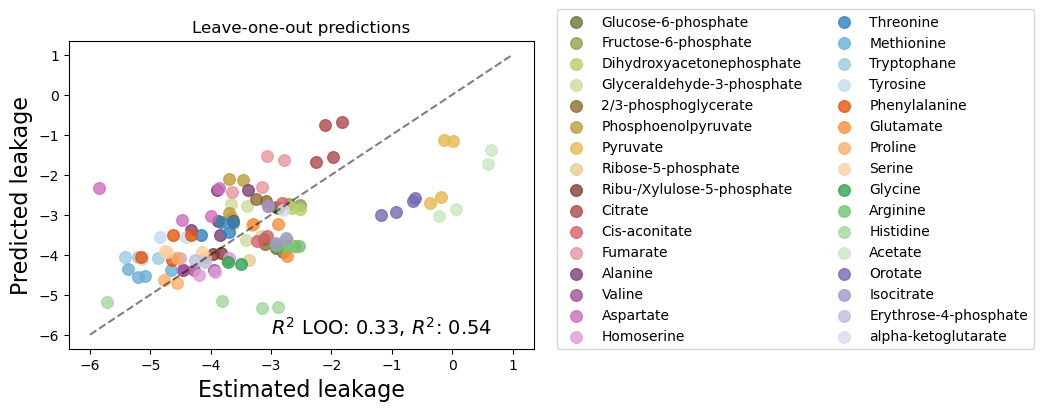

In [161]:
fig, ax = plt.subplots(1, figsize = (6, 4))
ypreds = []
yvals = []
mnames = tmp['Metabolite name'].unique()
for i, mname in enumerate(mnames):
    idx = tmp['Metabolite name']==mname
    linear_reg = LinearRegression(fit_intercept = True).fit(np.array(tmp.loc[~idx, columns]),y[~idx])
    Xi = np.array(tmp.loc[idx, columns])#reshape(1,-1)
    yi = linear_reg.predict(Xi)
    ypreds += list(yi)
    yvals += list(y[idx])
    ax.scatter(y[idx], yi, color = cmap40(i), label = mname,s = 70, alpha = 0.8)
# plt.scatter(ypreds, y)
l = np.linspace(-6,1)
plt.plot(l,l,c='k',ls = '--', alpha = 0.5)
plt.legend(ncol = 2, loc = (1.05, 0))
ypreds = np.array(ypreds)
yvals = np.array(yvals)

SSres = np.sum((ypreds-yvals)**2)
SStot = np.sum((yvals-np.mean(yvals))**2)
R2 = 1-(SSres/SStot)
print(R2)

X = sm.add_constant(np.array(tmp[columns]))
model = sm.OLS(y, X)
res = model.fit()

# RF


plt.xlabel('Estimated leakage', fontdict={'size': 16})
plt.ylabel('Predicted leakage', fontdict={'size': 16})
plt.title('Leave-one-out predictions')
plt.text(-3, -6, "$R^2$ LOO: {0:.2f}, $R^2$: {1:.2f}".format(R2, res.rsquared), fontdict={'size': 14})

-0.10700891890802855


Text(-3, -6, '$R^2$ LOO: -0.11, $R^2$: 0.32')

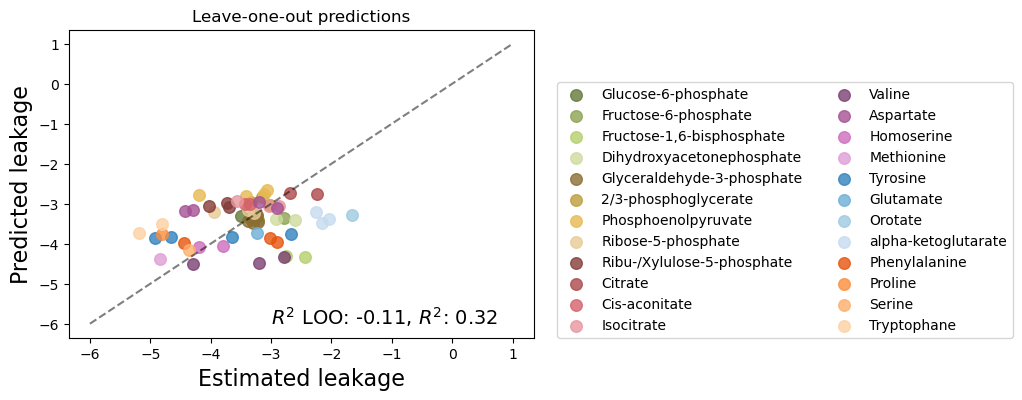

In [79]:
dft = df.loc[df.Time.isin([8.5, 9.5, 10.5, 11.5]), :]
columns =['Charge', 'Topological Polar Surface Area [Å]', 'High log10(-Shadow price)', 'log10(Turnover [mmol/gDW/h])', 'log P']
# columns = ['log10(-Shadow price [gDW/mmol])']
tmp = dft.loc[~dft['Leakage (mmol/gDW/h)'].isna(),columns+['log10(Leakage [mmol/gDW/h])', 'Metabolite name']]
# tmp['log10(Turnover [mmol/gDW/h])'].fillna(0, inplace = True) #tmp['log10(Turnover)']
tmp.dropna(inplace=True)
y = tmp['log10(Leakage [mmol/gDW/h])']


fig, ax = plt.subplots(1, figsize = (6, 4))
ypreds = []
yvals = []
mnames = tmp['Metabolite name'].unique()
for i, mname in enumerate(mnames):
    idx = tmp['Metabolite name']==mname
    linear_reg = LinearRegression(fit_intercept = True).fit(np.array(tmp.loc[~idx, columns]),y[~idx])
    Xi = np.array(tmp.loc[idx, columns])#reshape(1,-1)
    yi = linear_reg.predict(Xi)
    ypreds += list(yi)
    yvals += list(y[idx])
    ax.scatter(y[idx], yi, color = cmap40(i), label = mname,s = 70, alpha = 0.8)
# plt.scatter(ypreds, y)
l = np.linspace(-6,1)
plt.plot(l,l,c='k',ls = '--', alpha = 0.5)
plt.legend(ncol = 2, loc = (1.05, 0))
ypreds = np.array(ypreds)
yvals = np.array(yvals)

SSres = np.sum((ypreds-yvals)**2)
SStot = np.sum((yvals-np.mean(yvals))**2)
R2 = 1-(SSres/SStot)
print(R2)

X = sm.add_constant(np.array(tmp[columns]))
model = sm.OLS(y, X)
res = model.fit()

# RF


plt.xlabel('Estimated leakage', fontdict={'size': 16})
plt.ylabel('Predicted leakage', fontdict={'size': 16})
plt.title('Leave-one-out predictions')
plt.text(-3, -6, "$R^2$ LOO: {0:.2f}, $R^2$: {1:.2f}".format(R2, res.rsquared), fontdict={'size': 14})

In [163]:
cols_for_corr =['Mass', 'Predicted growth rate', 'Charge', 'Topological Polar Surface Area [Å]', 'log10(-Shadow price [gDW/mmol])', 'log10(Turnover [mmol/gDW/h])', 'log P']
all_sets = [list(x) for x in utils.powerset(cols_for_corr) if len(x)]
len(all_sets)

127

In [164]:
R2_arr = np.zeros(len(all_sets))
dft = df.loc[df.Time.isin([4.5, 5.5, 6.5, 7.5]), :]
# dft['test'] = dft['Shadow price']*dft['Predicted growth rate']

R2_full = []
for j, cols in enumerate(all_sets):
    tmp = dft.loc[~dft['Leakage (mmol/gDW/h)'].isna(),cols+['log10(Leakage [mmol/gDW/h])', 'Metabolite name']]
    # tmp['log10(Turnover [mmol/gDW/h])'].fillna(0, inplace = True) #tmp['log10(Turnover)']
    tmp.replace([np.inf, -np.inf], np.nan, inplace=True)
    tmp.dropna(inplace=True)
    tmp.reset_index(inplace = True)
    y = tmp['log10(Leakage [mmol/gDW/h])']
    ypreds = []
    yvals = []
    mnames = tmp['Metabolite name'].unique()
    for i, mname in enumerate(mnames):
        idx = tmp['Metabolite name']==mname
        linear_reg = LinearRegression(fit_intercept = True).fit(np.array(tmp.loc[~idx, cols]),y[~idx])
        Xi = np.array(tmp.loc[idx, cols])#reshape(1,-1)
        yi = linear_reg.predict(Xi)
        ypreds += list(yi)
        yvals += list(y[idx])
        
    X = sm.add_constant(np.array(tmp[cols]))
    model = sm.OLS(y, X)
    res = model.fit()
    R2_full.append(res.rsquared)
       
    ypreds = np.array(ypreds)
    yvals = np.array(yvals)

    SSres = np.sum((ypreds-yvals)**2)
    SStot = np.sum((yvals-np.mean(yvals))**2)
    R2 = 1-(SSres/SStot)
    R2_arr[j] = R2
    
  


In [165]:
labels = []
lengths = []
for cols in all_sets:
    cols = list(cols)
    lengths.append(len(cols))
    if len(cols) > 1:
        n = ", ".join(cols)
        labels.append(n)
    else:
        labels.append(cols[0])
    
R2df = pd.DataFrame([labels, R2_arr, R2_full, lengths]).T
R2df.columns = ['Label', 'R2 LOO', 'R2', 'N params']

In [166]:
R2df.sort_values('R2 LOO', ascending=False, inplace=True)
R2df.head(12)

,Label,R2 LOO,R2,N params
125,"Predicted growth rate, Charge, Topological Pol...",0.372777,0.577315,6
114,"Predicted growth rate, Charge, Topological Pol...",0.367428,0.53051,5
120,"Mass, Predicted growth rate, Charge, Topologic...",0.353507,0.542911,6
126,"Mass, Predicted growth rate, Charge, Topologic...",0.343958,0.58295,7
118,"Charge, Topological Polar Surface Area [Å], lo...",0.334103,0.543978,5
94,"Charge, Topological Polar Surface Area [Å], lo...",0.330516,0.495811,4
109,"Mass, Charge, Topological Polar Surface Area [...",0.328437,0.517361,5
124,"Mass, Charge, Topological Polar Surface Area [...",0.313304,0.555699,6
51,"Predicted growth rate, log10(-Shadow price [gD...",0.288804,0.420275,3
26,"log10(-Shadow price [gDW/mmol]), log P",0.28643,0.410177,2


In [167]:
for x in R2df.head(10)['Label']:
    print(x)

Predicted growth rate, Charge, Topological Polar Surface Area [Å], log10(-Shadow price [gDW/mmol]), log10(Turnover [mmol/gDW/h]), log P
Predicted growth rate, Charge, Topological Polar Surface Area [Å], log10(-Shadow price [gDW/mmol]), log P
Mass, Predicted growth rate, Charge, Topological Polar Surface Area [Å], log10(-Shadow price [gDW/mmol]), log P
Mass, Predicted growth rate, Charge, Topological Polar Surface Area [Å], log10(-Shadow price [gDW/mmol]), log10(Turnover [mmol/gDW/h]), log P
Charge, Topological Polar Surface Area [Å], log10(-Shadow price [gDW/mmol]), log10(Turnover [mmol/gDW/h]), log P
Charge, Topological Polar Surface Area [Å], log10(-Shadow price [gDW/mmol]), log P
Mass, Charge, Topological Polar Surface Area [Å], log10(-Shadow price [gDW/mmol]), log P
Mass, Charge, Topological Polar Surface Area [Å], log10(-Shadow price [gDW/mmol]), log10(Turnover [mmol/gDW/h]), log P
Predicted growth rate, log10(-Shadow price [gDW/mmol]), log P
log10(-Shadow price [gDW/mmol]), log P

In [1245]:
Mass, Charge, Topological Polar Surface Area [Å], log10(-Shadow price [gDW/mmol]), log P

SyntaxError: invalid syntax (1941492499.py, line 1)

Text(0, 0.5, '$R^2$ for leave-one-out CV')

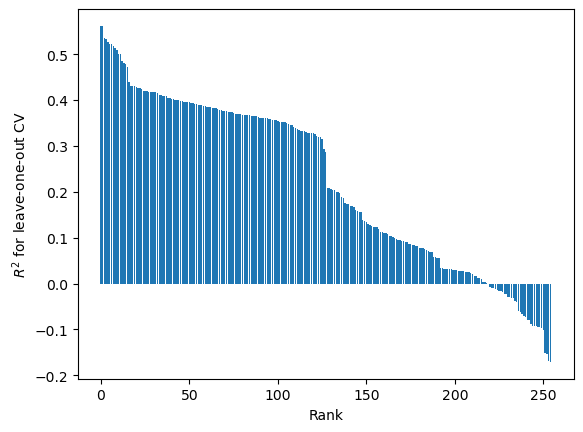

In [118]:
plt.bar(np.arange(len(R2_arr)), R2df['R2 LOO'])
plt.xlabel('Rank')
plt.ylabel('$R^2$ for leave-one-out CV')

In [778]:
ypreds = []
for i, idx in enumerate(tmp.index):
    linear_reg = LinearRegression(fit_intercept = True).fit(np.array(tmp[columns].drop(idx)),y.drop(idx))
    Xi = np.array(tmp.loc[idx, columns]).reshape(1,-1)
    ypreds.append(linear_reg.predict(Xi)[0])

plt.scatter(ypreds, y)
l = np.linspace(-5,-2)
plt.plot(l,l,c='k',ls = '--', alpha = 0.5)

SSres = np.sum((ypreds-y)**2)
SStot = np.sum((y-np.mean(y))**2)
R2 = 1-(SSres/SStot)
print(R2)

ValueError: Expected 2D array, got 1D array instead:
array=[336.083922    -4.           2.         215.          -1.22312431
   0.          -5.9       ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [739]:
Xi

array([[-1.72616154,  0.96220954, -1.2338501 ,  0.79949215, -1.28492111,
         0.80697458]])

In [1025]:
X = sm.add_constant(tmp[columns])
model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:     log10(Leakage [mmol/gDW/h])   R-squared:                       0.413
Model:                                     OLS   Adj. R-squared:                  0.403
Method:                          Least Squares   F-statistic:                     42.89
Date:                         Mon, 26 Jun 2023   Prob (F-statistic):           1.37e-08
Time:                                 11:45:44   Log-Likelihood:                -89.887
No. Observations:                           63   AIC:                             183.8
Df Residuals:                               61   BIC:                             188.1
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

0.6336057273870643


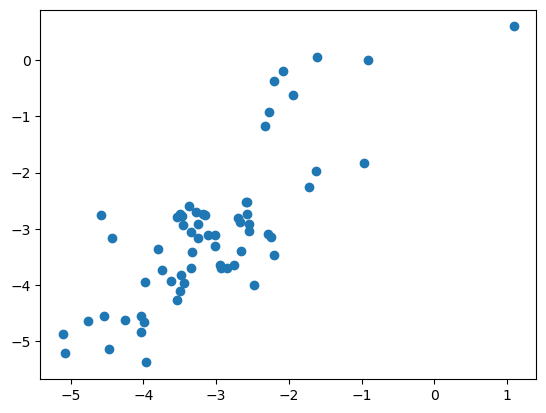

In [763]:
plt.scatter(res.predict(), y)
ypreds = res.predict()
SSres = np.sum((ypreds-y)**2)
SStot = np.sum((y-np.mean(y))**2)
R2 = 1-(SSres/SStot)
print(R2)

In [1023]:
X = sm.add_constant(StandardScaler().fit_transform(tmp[columns]))
model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:     log10(Leakage [mmol/gDW/h])   R-squared:                       0.413
Model:                                     OLS   Adj. R-squared:                  0.403
Method:                          Least Squares   F-statistic:                     42.89
Date:                         Mon, 26 Jun 2023   Prob (F-statistic):           1.37e-08
Time:                                 11:45:14   Log-Likelihood:                -89.887
No. Observations:                           63   AIC:                             183.8
Df Residuals:                               61   BIC:                             188.1
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [1028]:
np.log10

<ufunc 'log10'>

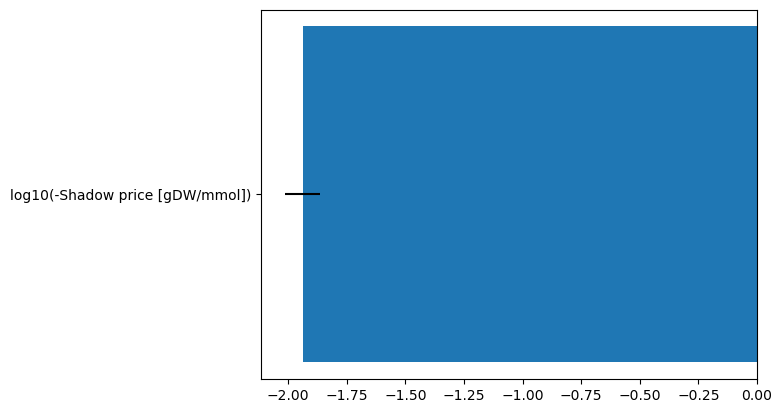

In [1027]:
N = 100
coefficients = np.zeros((2,N))*np.nan

R2_arr_oo = np.zeros(N)
R2_arr = np.zeros(N)
R2_arr_test = np.zeros(N)
# data = StandardScaler().fit_transform(tmp[columns])
data = sm.add_constant(tmp[columns])

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.05)#, random_state=40)
    linear_reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)
    coefficients[:, i] = linear_reg.coef_
    R2_arr[i] = linear_reg.score(X_train, y_train)
    R2_arr_oo[i] = linear_reg.score(X_test, y_test)

plt.barh(columns, coefficients.mean(axis=1), xerr = coefficients.std(axis=1))
plt.show()

In [600]:
X_test.shape

(2, 2)

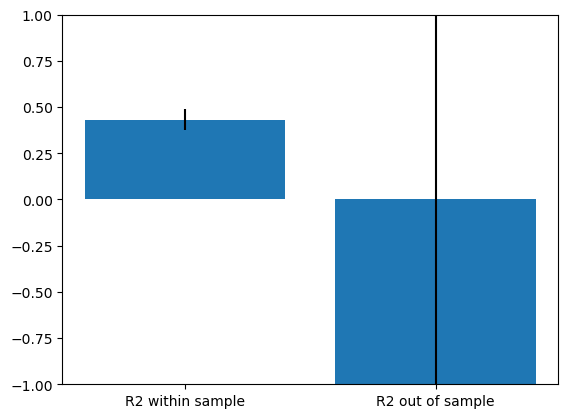

In [601]:
fig, ax = plt.subplots(1)
ax.bar(["R2 within sample", "R2 out of sample"], [R2_arr.mean(), R2_arr_oo.mean()], yerr = [R2_arr.std(), R2_arr_oo.std()])
ax.set_ylim(-1, 1)
plt.show()

In [443]:
dft = df.loc[df.Time==6.5, :]
tmp = dft.loc[~dft.isna().any(axis =1),:]
y = tmp['log10(leakage [mmol/gDW/h])']
X = tmp['Shadow price [gDW/mmol]']


In [444]:
X = np.array(X).reshape(-1,1)
# x = np.array(y).reshape(-1,1)

In [445]:
lr = linear_model.LinearRegression(fit_intercept = True)
ransac = linear_model.RANSACRegressor()

In [446]:
lr.fit(X,y)
ransac.fit(X,y)

RANSACRegressor()

In [452]:
line_X = np.linspace(X.min(), X.max(), 10)[:, np.newaxis]

In [453]:
y1 = lr.predict(line_X)
y2 = ransac.predict(line_X)

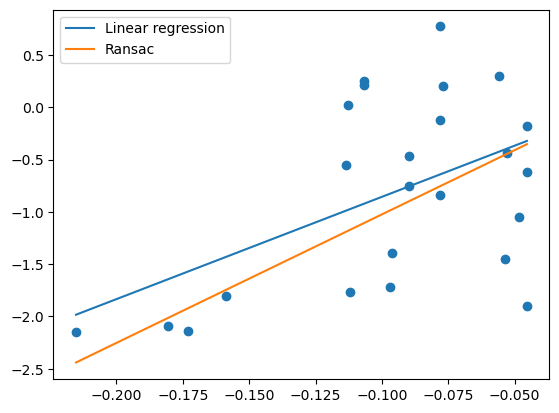

In [457]:
plt.scatter(X,y)
plt.plot(line_X, y1, label = 'Linear regression')
plt.plot(line_X, y2, label = 'Ransac')
plt.legend()

In [451]:
y1

array([-1.98323264])